In [1]:
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

In [2]:
class InventoryManagementEnv(gym.Env):
    """
    A simplified perishable inventory management environment.
    We assume a single product with a fixed shelf-life of 3 days.

    State:
      inventory: A vector [I_3, I_2, I_1] where:
         I_3: number of items with 3 days left (fresh)
         I_2: number of items with 2 days left
         I_1: number of items with 1 day left (needs discount sale)

    Actions:
      Discrete integer representing the number of new items to order (0 to max_order).
      New orders are assumed to arrive immediately and have full shelf-life (3 days).

    Dynamics:
      - At each day, the inventory ages:
            [I_3, I_2, I_1] -> [new_order, I_3, I_2]
         (I_1 items expire and are wasted)
      - Demand is generated (e.g., using a Poisson distribution).
      - Sales are fulfilled prioritizing items that are closer to expiration:
          * Items with 1 day left (discounted sales, lower revenue)
          * Then items with 2 or 3 days left (full price)

    Reward:
      Revenue from sales minus ordering cost and waste penalty for expired items.
      Example parameters:
         full_price = $10, discount_price = $5
         order_cost = $7 per item
         waste_penalty = $3 per expired item.
    """
    metadata = {'render.modes': ['human']}

    def __init__(self):
        super(InventoryManagementEnv, self).__init__()

        # Define action and observation space
        # Action: order quantity between 0 and 10
        self.max_order = 10
        self.action_space = spaces.Discrete(self.max_order + 1)

        # Observation: 3-dimensional vector for inventory counts (I_3, I_2, I_1)
        self.observation_space = spaces.Box(low=0, high=100, shape=(3,), dtype=np.int32)

        # Parameters
        self.full_price = 10.0
        self.discount_price = 5.0
        self.order_cost = 7.0
        self.waste_penalty = 3.0

        # Demand parameters (Poisson demand)
        self.demand_lambda = 5

        # Maximum simulation length (episode length)
        self.max_days = 100

        # Initialize state
        self.reset()

    def reset(self):
        # Start with empty inventory
        self.inventory = np.array([0, 0, 0], dtype=np.int32)
        self.day = 0
        return self._get_obs()

    def _get_obs(self):
        # Return the inventory vector as observation (convert to float for NN compatibility)
        return self.inventory.astype(np.float32)

    def step(self, action):
        """
        Action is the number of items to order.
        """
        done = False
        info = {}
        reward = 0.0

        # 1. Age the inventory:
        # Items with 1 day left expire (waste)
        expired = self.inventory[2]

        # Apply waste penalty
        reward -= self.waste_penalty * expired

        # Shift inventory: I_3 -> I_2, I_2 -> I_1, and expired items are removed
        self.inventory[2] = self.inventory[1]
        self.inventory[1] = self.inventory[0]
        # New order arrives with shelf-life 3
        new_order = int(action)
        self.inventory[0] = new_order

        # Ordering cost
        reward -= self.order_cost * new_order

        # 2. Simulate demand (random, using Poisson)
        demand = np.random.poisson(self.demand_lambda)

        # 3. Fulfill demand, prioritizing items closer to expiration
        sales = 0
        revenue = 0.0
        remaining_demand = demand

        # Sell discounted items first (I_1 items)
        sell_from_I1 = min(self.inventory[2], remaining_demand)
        revenue += sell_from_I1 * self.discount_price
        self.inventory[2] -= sell_from_I1
        remaining_demand -= sell_from_I1
        sales += sell_from_I1

        # Sell full price from I_2 items next
        sell_from_I2 = min(self.inventory[1], remaining_demand)
        revenue += sell_from_I2 * self.full_price
        self.inventory[1] -= sell_from_I2
        remaining_demand -= sell_from_I2
        sales += sell_from_I2

        # Sell full price from I_3 items last
        sell_from_I3 = min(self.inventory[0], remaining_demand)
        revenue += sell_from_I3 * self.full_price
        self.inventory[0] -= sell_from_I3
        remaining_demand -= sell_from_I3
        sales += sell_from_I3

        reward += revenue

        self.day += 1
        if self.day >= self.max_days:
            done = True

        obs = self._get_obs()
        return obs, reward, done, info

    def render(self, mode='human'):
        print(f"Day: {self.day}, Inventory: {self.inventory}")

In [3]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        # A simple fully connected network
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


In [4]:
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
def train_dqn(env, num_episodes=500, batch_size=32, gamma=0.99,
              epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995,
              target_update=10, memory_capacity=10000, learning_rate=1e-3):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    policy_net = DQN(state_dim, action_dim).to(device)
    target_net = DQN(state_dim, action_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
    memory = ReplayMemory(memory_capacity)

    episode_rewards = []
    epsilon = epsilon_start

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done = False

        while not done:
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                with torch.no_grad():
                    q_values = policy_net(state_tensor)
                action = int(torch.argmax(q_values, dim=1).item())

            next_state, reward, done, _ = env.step(action)
            total_reward += reward

            # Store the experience in replay memory
            memory.push(state, action, reward, next_state, done)
            state = next_state

            # Sample a batch and train
            if len(memory) >= batch_size:
                transitions = memory.sample(batch_size)
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = zip(*transitions)

                batch_state = torch.FloatTensor(batch_state).to(device)
                batch_action = torch.LongTensor(batch_action).unsqueeze(1).to(device)
                batch_reward = torch.FloatTensor(batch_reward).unsqueeze(1).to(device)
                batch_next_state = torch.FloatTensor(batch_next_state).to(device)
                batch_done = torch.FloatTensor(batch_done).unsqueeze(1).to(device)

                # Compute current Q values
                current_q = policy_net(batch_state).gather(1, batch_action)
                # Compute next Q values from target network
                with torch.no_grad():
                    max_next_q = target_net(batch_next_state).max(1)[0].unsqueeze(1)
                target_q = batch_reward + gamma * max_next_q * (1 - batch_done)

                # Compute loss
                loss = nn.MSELoss()(current_q, target_q)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Decay epsilon
        epsilon = max(epsilon_end, epsilon * epsilon_decay)
        episode_rewards.append(total_reward)

        # Update target network periodically
        if episode % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if (episode + 1) % 10 == 0:
            print(f"Episode {episode+1}/{num_episodes}, Total Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")

    return episode_rewards, policy_net

Using device: cuda


<ipython-input-5-d68bd11846fe>:49: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  batch_state = torch.FloatTensor(batch_state).to(device)


Episode 10/300, Total Reward: -249.00, Epsilon: 0.951
Episode 20/300, Total Reward: 721.00, Epsilon: 0.905
Episode 30/300, Total Reward: 610.00, Epsilon: 0.860
Episode 40/300, Total Reward: 875.00, Epsilon: 0.818
Episode 50/300, Total Reward: 703.00, Epsilon: 0.778
Episode 60/300, Total Reward: 437.00, Epsilon: 0.740
Episode 70/300, Total Reward: 584.00, Epsilon: 0.704
Episode 80/300, Total Reward: 450.00, Epsilon: 0.670
Episode 90/300, Total Reward: 881.00, Epsilon: 0.637
Episode 100/300, Total Reward: 885.00, Epsilon: 0.606
Episode 110/300, Total Reward: 790.00, Epsilon: 0.576
Episode 120/300, Total Reward: 896.00, Epsilon: 0.548
Episode 130/300, Total Reward: 1057.00, Epsilon: 0.521
Episode 140/300, Total Reward: 1068.00, Epsilon: 0.496
Episode 150/300, Total Reward: 1087.00, Epsilon: 0.471
Episode 160/300, Total Reward: 691.00, Epsilon: 0.448
Episode 170/300, Total Reward: 968.00, Epsilon: 0.427
Episode 180/300, Total Reward: 961.00, Epsilon: 0.406
Episode 190/300, Total Reward: 87

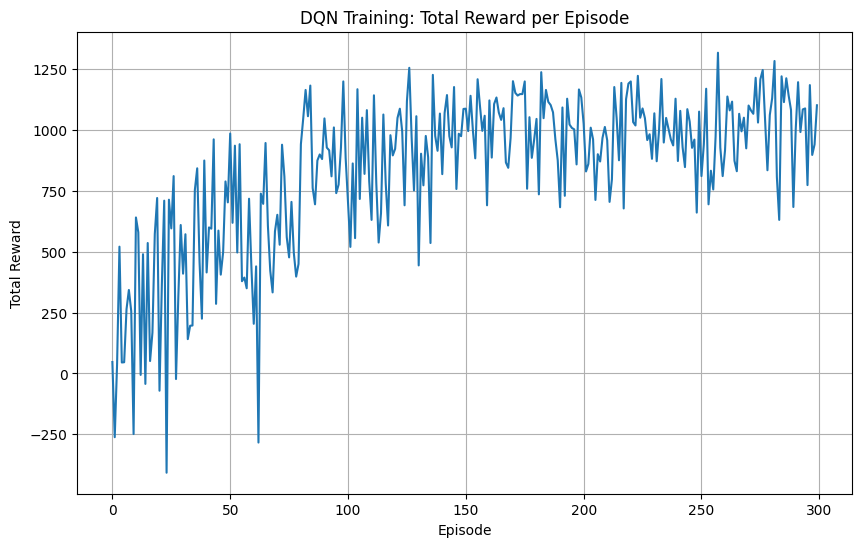

In [6]:
env = InventoryManagementEnv()
num_episodes = 300  # adjust as needed
rewards, trained_policy = train_dqn(env, num_episodes=num_episodes)

# Plot total rewards per episode
plt.figure(figsize=(10,6))
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training: Total Reward per Episode")
plt.grid(True)
plt.show()
